In [4]:
import tensorflow as tf
from tensorflow.keras import datasets,layers,models
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-04-01 13:34:08.090598: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(train_images,train_labels),(test_images,test_labels) = datasets.mnist.load_data()

In [3]:
val_p = 0.2
num_val = int(len(train_images) * val_p)
x_train, x_val = train_images[:-num_val], train_images[-num_val:]
y_train, y_val = train_labels[:-num_val], train_labels[-num_val:]

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(train_images)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).shuffle(len(x_val)).batch(32)  # 使用 x_val 的长度
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32)

In [4]:
train_images,test_images = train_images/255.0,test_images/255.0

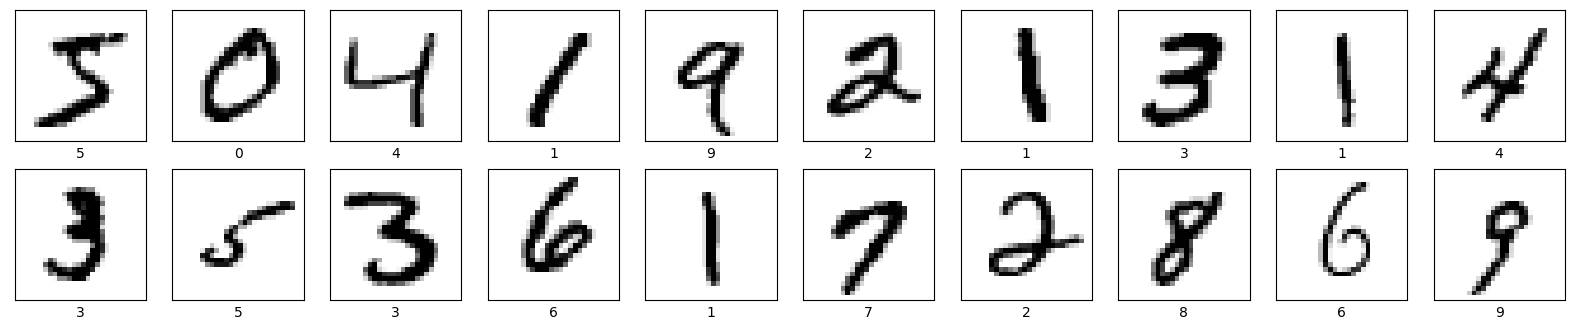

In [5]:
plt.figure(figsize=(20,10))
for i in range(20):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i],cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

In [6]:
train_images = train_images.reshape((60000,28,28,1))
test_images = test_images.reshape(10000,28,28,1)

train_dataset,val_dataset,test_dataset

(<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>)

In [7]:
'''
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        affine - relu - dropout - affine - dropout - softmax
'''
model = models.Sequential()


model.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1), kernel_regularizer=l2(0.001)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPool2D(2, 2))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Conv2D(32, (1, 1), activation='relu'))
model.add(layers.MaxPool2D(2, 2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10))


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 16)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 32)        1056      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                   

In [9]:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
import time
import os
from tensorflow.keras.callbacks import TensorBoard
model_name = "model-{}".format(int(time.time()))
logdir = os.path.join('logs', model_name)
if not os.path.exists(logdir):
    os.makedirs(logdir)

tensorboard = TensorBoard(log_dir=logdir, histogram_freq=1, write_graph=True, write_images=True, update_freq='epoch')

In [12]:
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))  # 添加通道维度
train_datagen = ImageDataGenerator(rescale=1./255,
                                rotation_range=10,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                # 添加更多的数据增强技术
                                zoom_range=0.2)  # 随机缩放
train_generator = train_datagen.flow(x_train, y_train, batch_size=32)



early_stopping = EarlyStopping(monitor='val_loss', patience=7)

In [13]:
history = model.fit(train_generator, epochs=15, validation_data=(val_dataset), steps_per_epoch=len(x_train)//32, callbacks=[early_stopping, tensorboard])

Epoch 1/15
1500/1500 [==============================] - 38s 24ms/step - loss: 0.6567 - accuracy: 0.7746 - val_loss: 19.0099 - val_accuracy: 0.9578
Epoch 2/15
1500/1500 [==============================] - 37s 25ms/step - loss: 0.2548 - accuracy: 0.9234 - val_loss: 11.4012 - val_accuracy: 0.9773
Epoch 3/15
1500/1500 [==============================] - 38s 25ms/step - loss: 0.1920 - accuracy: 0.9437 - val_loss: 11.6119 - val_accuracy: 0.9778
Epoch 4/15
1500/1500 [==============================] - 38s 25ms/step - loss: 0.1588 - accuracy: 0.9527 - val_loss: 8.4445 - val_accuracy: 0.9792
Epoch 5/15
1500/1500 [==============================] - 38s 25ms/step - loss: 0.1418 - accuracy: 0.9585 - val_loss: 9.0826 - val_accuracy: 0.9805
Epoch 6/15
1500/1500 [==============================] - 38s 25ms/step - loss: 0.1242 - accuracy: 0.9629 - val_loss: 9.2661 - val_accuracy: 0.9822
Epoch 7/15
1500/1500 [==============================] - 39s 26ms/step - loss: 0.1178 - accuracy: 0.9661 - val_loss: 9.826

In [14]:
from datetime import datetime
current_time = datetime.now()
model.save(str(current_time)+'.h5')

/Users/williamtiger/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


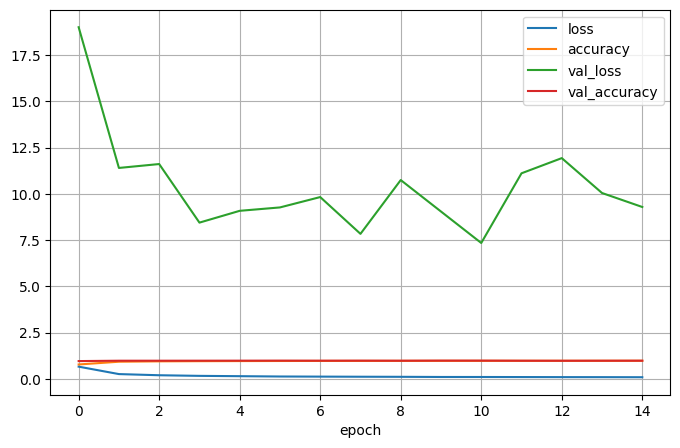

In [15]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('epoch')
plt.show()

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)
test_loss,test_acc

313/313 [==============================] - 1s 4ms/step - loss: 8.3443 - accuracy: 0.9809


(8.344255447387695, 0.98089998960495)

In [5]:
model = tf.keras.models.load_model('2024-03-29 16:42:41.299832.h5')

In [6]:
import numpy as np
from PIL import Image

# 定义类别名称
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# 循环处理每个图像
for i in range(1, 10):  # 假设您有数字1到10的图像
    image = Image.open(str(i) + ".jpg").convert('L')
    new_size = (28, 28)
    image = image.resize(new_size)
    image.save('test.jpg')
    image_array = np.array(image)
    image_array = np.expand_dims(image_array, axis=0)
    image_array = image_array.astype('float32')
    image_array /= 255.0  # 归一化

    # 模型预测
    pre = model.predict(image_array)
    predicted_class_index = np.argmax(pre)
    predicted_class = class_names[predicted_class_index]
    print(f"Predicted number for image {i}: {predicted_class}")

1/1 [==============================] - 0s 227ms/step
Predicted number for image 1: 1
1/1 [==============================] - 0s 15ms/step
Predicted number for image 2: 2
1/1 [==============================] - 0s 15ms/step
Predicted number for image 3: 3
1/1 [==============================] - 0s 20ms/step
Predicted number for image 4: 4
1/1 [==============================] - 0s 16ms/step
Predicted number for image 5: 5
1/1 [==============================] - 0s 17ms/step
Predicted number for image 6: 6
1/1 [==============================] - 0s 17ms/step
Predicted number for image 7: 7
1/1 [==============================] - 0s 15ms/step
Predicted number for image 8: 8
1/1 [==============================] - 0s 17ms/step
Predicted number for image 9: 9


In [8]:
image = Image.open("test.jpg").convert('L')
new_size = (28, 28)
image = image.resize(new_size)
image.save('test.jpg')
image_array = np.array(image)
image_array = np.expand_dims(image_array, axis=0)
image_array = image_array.astype('float32')
image_array /= 255.0  # 归一化
# 模型预测
pre = model.predict(image_array)
predicted_class_index = np.argmax(pre)
predicted_class = class_names[predicted_class_index]
print(f"Predicted number for image {3}: {predicted_class}")

1/1 [==============================] - 0s 139ms/step
Predicted number for image 3: 8
